# Fichier de synthèse pour entrainer le modèle Random Forest sur le dataset

---
## Importation des librairies

In [1]:
# Import of all necessary librairies
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, precision_recall_curve, make_scorer, fbeta_score
from sklearn.feature_selection import SelectKBest
from sklearn.inspection import permutation_importance
import sklearn
from scipy.stats import randint
from utils import text_to_numeric, get_upper_matrix, get_correlated, create_pipeline, remove_redundancy
import matplotlib.pyplot as plt
import seaborn as sns
import shap

c:\Users\titig\Documents\formation_data_ia\09_classifiez_des_infos_avec_le_ml\projet\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
## Configuration des librairies

In [2]:
pd.set_option('display.max_columns', None) # Let the dataframe to be fully displayed
#sklearn.set_config(transform_output='pandas') # Keep the pandas structure and not Numpy 

---
## Importation des données

In [3]:
# Import all files
df_sirh = pd.read_csv("../data/extrait_sirh.csv")
df_sondage = pd.read_csv("../data/extrait_sondage.csv")
df_eval = pd.read_csv("../data/extrait_eval.csv")

### Display the dataframes from files

#### Dataframe SIRH

In [4]:
df_sirh.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2


#### Dataframe sondage

In [5]:
df_sondage.head()

,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0
3,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0
4,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2


#### Dataframe évaluation

In [6]:
df_eval.head()

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,2,3,2,4,1,1,E_1,3,Oui,11 %
1,3,2,2,2,4,3,E_2,4,Non,23 %
2,4,2,1,3,2,3,E_4,3,Oui,15 %
3,4,3,1,3,3,3,E_5,3,Oui,11 %
4,1,3,1,2,4,3,E_7,3,Non,12 %


---
## Merge des dataframes

### Préparation des données

In [7]:
df_eval['eval_number'] = text_to_numeric(df_eval['eval_number']) # Remove text and output as numeric

### Merge des dataframes

In [8]:
df_first_merge = pd.merge(df_sirh, df_sondage, how='outer', left_on='id_employee', right_on='code_sondage')
df_data = pd.merge(df_first_merge, df_eval, how='outer', left_on='id_employee', right_on='eval_number')
df_data.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5,2,3,2,4,1,1,1,3,Oui,11 %
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7,3,2,2,2,4,3,2,4,Non,23 %
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0,4,2,1,3,2,3,4,3,Oui,15 %
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0,4,3,1,3,3,3,5,3,Oui,11 %
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2,1,3,1,2,4,3,7,3,Non,12 %


---
## Préparation pour l'entrainement du modèle

### Spécification des features

In [9]:
# Specify the target column
target_column = "a_quitte_l_entreprise"

# From the analysis, I tag the useless features
useless_columns = [
    "id_employee",
    "eval_number",
    "code_sondage",
    "nombre_heures_travailless",
    "nombre_employee_sous_responsabilite",
    "ayant_enfants",
]

category_columns = [
    "genre",
    "statut_marital",
    "departement",
    "poste",
    "domaine_etude",
    "heure_supplementaires",
]

ordinales_columns = [
    "frequence_deplacement",
]

ordinales_categories = [
    ["Aucun", "Occasionnel", "Frequent"],
]

text_to_numeric_columns = ["augementation_salaire_precedente"]

### Nettoyage du dataframe

In [10]:
df_data.drop(columns=useless_columns, inplace=True)

### Transformation de la feature cible pour aider le modèle

In [11]:
df_data[target_column] = df_data[target_column].map({'Non': 0, 'Oui': 1})

### Séparation des features et de la target

In [12]:
X = df_data.drop(columns=target_column)
y = df_data[target_column]

### Préparation du jeu d'entrainement et de test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234, stratify=y
)

### Définition du preprocessor pour le modèle

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ("oneHot", OneHotEncoder(drop="first"), category_columns),
        ("ordinal", OrdinalEncoder(categories=ordinales_categories), ordinales_columns),
        (
            "textToNumeric",
            FunctionTransformer(text_to_numeric, feature_names_out="one-to-one"),
            text_to_numeric_columns,
        ),
    ],
    remainder="passthrough",
)

### Création de features maison

In [ ]:
def add_custom_features(X):
    X = X.copy()

    X['risque_burnout'] = X['distance_domicile_travail'] * X['heure_supplementaires'].apply(lambda x: 1 if x == 'Oui' else 0)
    X['volatilite'] = (10000 / (X['revenu_mensuel'] + 1)) * (X['statut_marital'].apply(lambda x:1 if x=="Célibataire" else 0.5)) * (1 / (X['annees_dans_l_entreprise'] + 1))
    X['stagnation'] = X['annees_dans_le_poste_actuel']  * X['annees_depuis_la_derniere_promotion']
    X['loyaute'] = (X['annees_dans_le_poste_actuel'] + 1) / (X['annes_sous_responsable_actuel'] + 1)

    return X

feature_engineering_step = ('engineering', FunctionTransformer(add_custom_features))

---
## Entrainement du modèle

### Définition de la pipeline

In [16]:
rf_pipeline = Pipeline(
    [
        feature_engineering_step,
        ("preprocessor", preprocessor),
        (
            "rf",
            RandomForestClassifier(
                random_state=1234, class_weight="balanced", min_samples_split=10
            ),
        ),
    ]
)

### Définition des hyper paramètres

In [17]:
grid_parameters = {
    "rf__max_depth": [3, 5, 8, 10],
    "rf__n_estimators": randint(50, 500),
    "rf__min_samples_leaf": randint(2, 20),
    "rf__max_features": ["sqrt", "log2"],
}

### Utilisation du Randomized Search

In [18]:
random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=grid_parameters,
    n_iter=100,
    cv=5,
    scoring="f1",
    n_jobs=-1,
)

random_search.fit(X_train, y_train)

print(f"Meilleurs paramètres : {random_search.best_params_}")
print(f"Meilleurs F1 scores en validation croisée: {random_search.best_score_:.3f}")

Meilleurs paramètres : {'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 19, 'rf__n_estimators': 498}
Meilleurs F1 scores en validation croisée: 0.486


On peut constater que le score moyen du modèle est moyen. 

Il faut vérifier avec les graphes pour voir les performances en fonction du besoin. 

---
## Visualisation des résultats du modèle

### Récupération des meilleurs paramètres

In [19]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

### Matrice de confusion

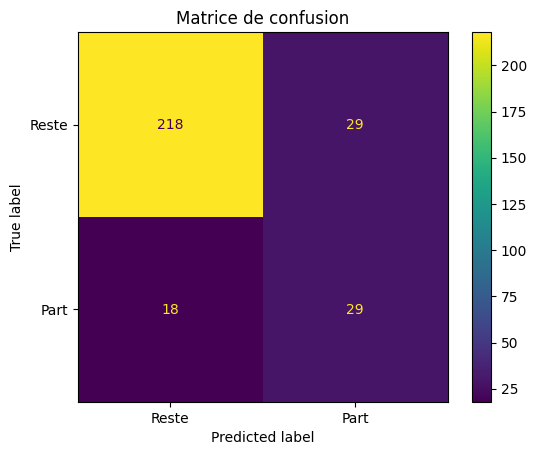

In [20]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["Reste", "Part"]
)
plt.title("Matrice de confusion")
plt.show()

Le modèle a tendance à privilégier un rappel plus élevé, ce qui est bénéfique dans notre cas. 

Il vaut mieux prédire le départ de quelqu'un et qu'il reste plutôt que l'inverse. 

Des moyens peuvent être mis en place pour faire baisser sa probabilité de partir et garder les salariés dans le futur. 

### Courbe Précision / Rappel

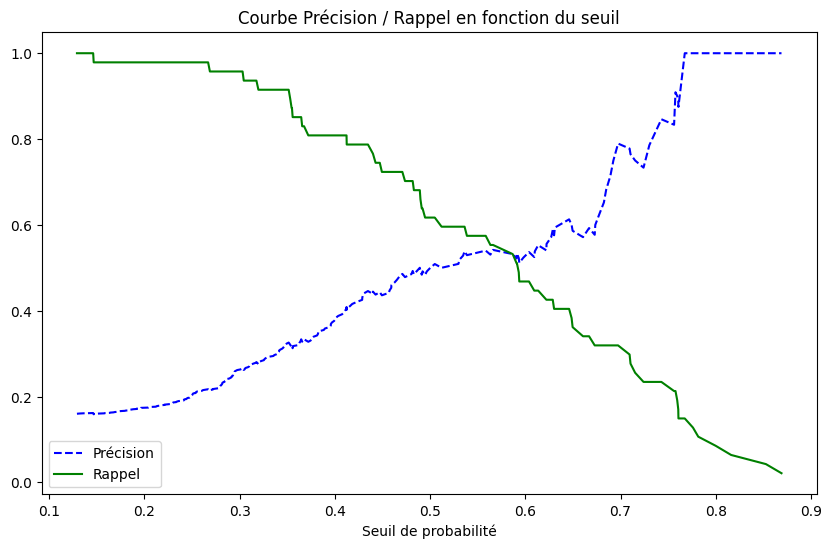

In [21]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[: -1], "b--", label="Précision")
plt.plot(thresholds, recalls[: -1], "g-", label="Rappel")
plt.xlabel("Seuil de probabilité")
plt.legend()
plt.title("Courbe Précision / Rappel en fonction du seuil")
plt.show()

Pour potentiellement avoir encore plus de salariés sur le départ, on pourrait abaisser le seuil de détection du modèle vers 0.4

### Rapport de test classification avec un seuil != 0.5

In [22]:
best_recall_threshold = 0.4

y_pred_recall = (y_proba >= best_recall_threshold).astype(int)
print(f"Résultats avec un seuil à {best_recall_threshold}")
print(classification_report(y_test, y_pred_recall))

Résultats avec un seuil à 0.4
              precision    recall  f1-score   support

           0       0.95      0.75      0.84       247
           1       0.38      0.81      0.52        47

    accuracy                           0.76       294
   macro avg       0.67      0.78      0.68       294
weighted avg       0.86      0.76      0.79       294



Malgré une chute de la précision attendue, on peut constater que le rappel est nettement supérieur. 

Le F1 score est d'ailleurs plus élevé qu'avec le seuil à 50%

### Matrice de confusion avec seuil modifié

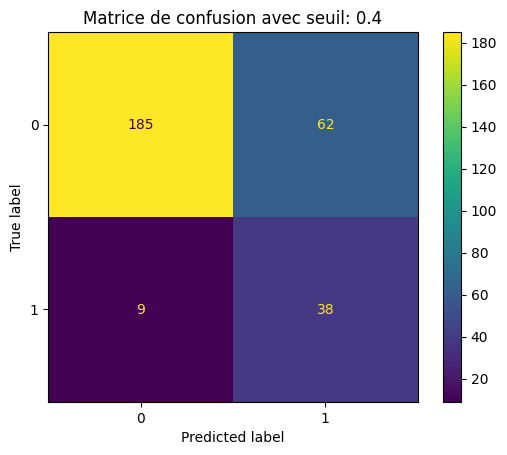

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_recall)
plt.title(f"Matrice de confusion avec seuil: {best_recall_threshold}")
plt.show()

## Etude de l'importance des features

### Récupération et process pour affichage des graphes

In [24]:
model = best_model.named_steps["rf"]  # Get the model config and features
features_name = best_model.named_steps[
    "preprocessor"
].get_feature_names_out()  # Get all preprocessor to execute

X_test_transformed = best_model.named_steps["preprocessor"].transform(
    add_custom_features(X_test)
)

### Importance native

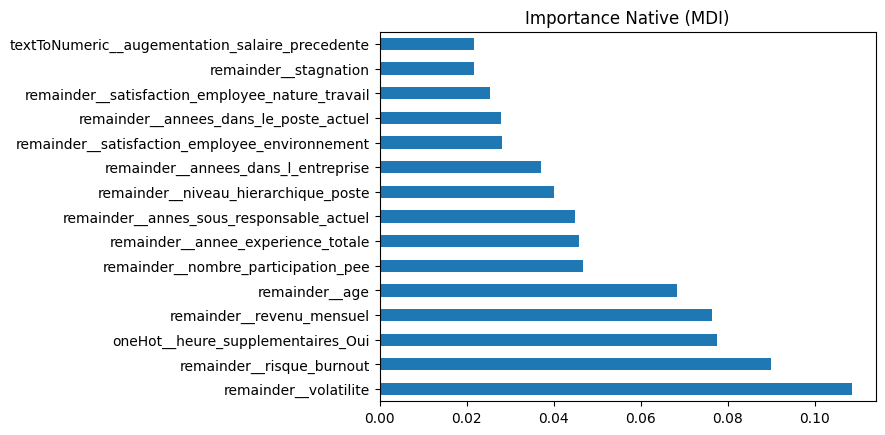

In [25]:
feature_importances = pd.Series(model.feature_importances_, index=features_name)
feature_importances.nlargest(15).plot(kind='barh', title="Importance Native (MDI)")
plt.show()

On peut constater que deux features maisons sont très importantes pour le modèle dans sa globalité

### Permutation importance

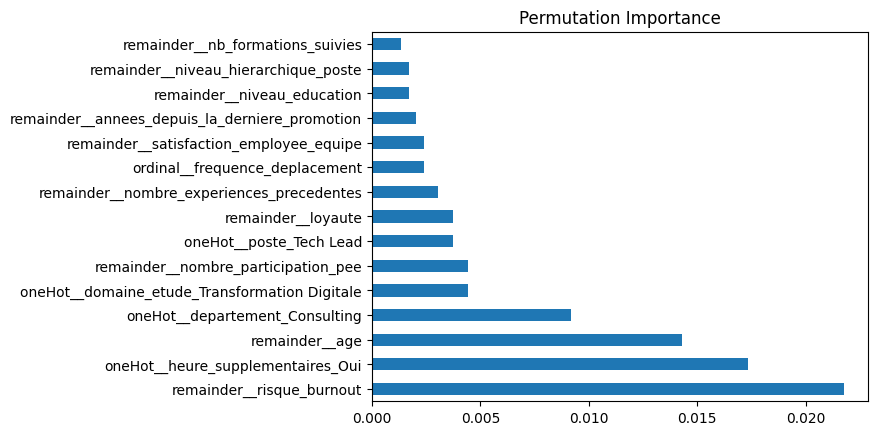

In [26]:
perm_importance = permutation_importance(model, X_test_transformed, y_test, n_repeats=10, random_state=1234)
pd.Series(perm_importance.importances_mean, index=features_name).nlargest(15).plot(kind='barh', title="Permutation Importance")
plt.show()

On peut constater que le département de Consulting permet de fortement catégoriser la réponse du modèle. 

D'autres features tel que le domaine d'étude dans la transformation digitale sont à prendre en compte. 

### Beeswarm

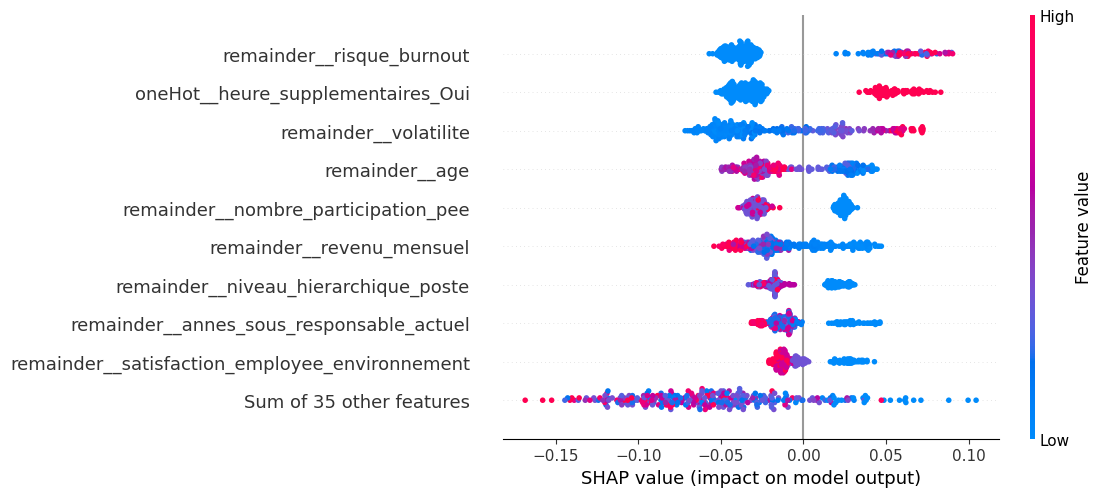

In [30]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test_transformed)
shap_values.feature_names = features_name
shap.plots.beeswarm(shap_values[:, :, 1])

### Waterfall plot

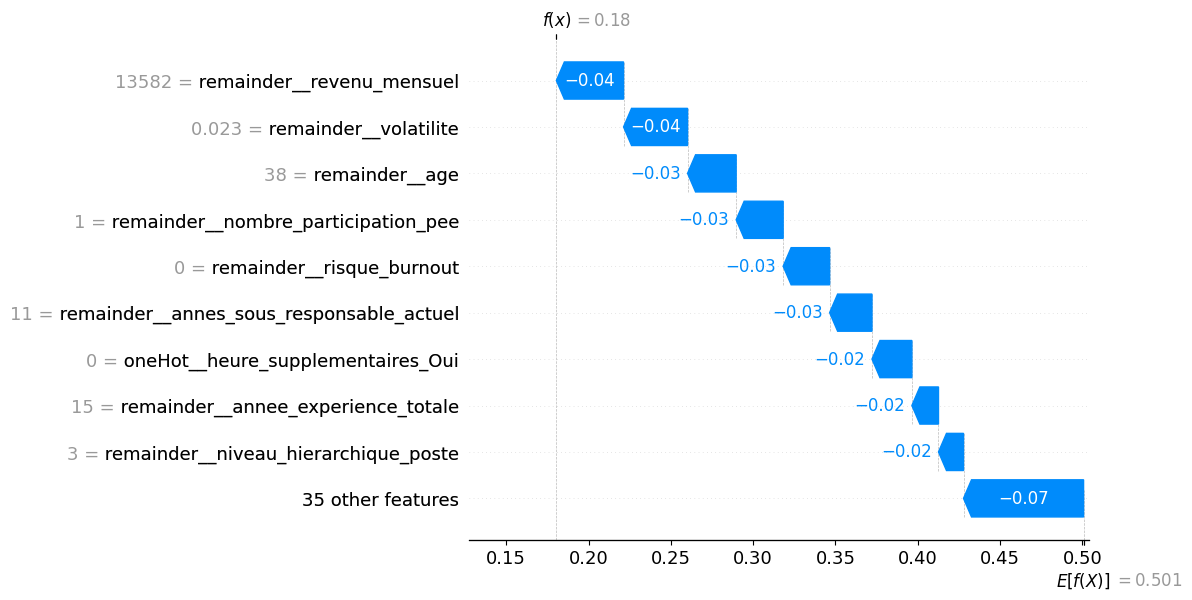

In [35]:
shap.plots.waterfall(shap_values[3, :, 1])

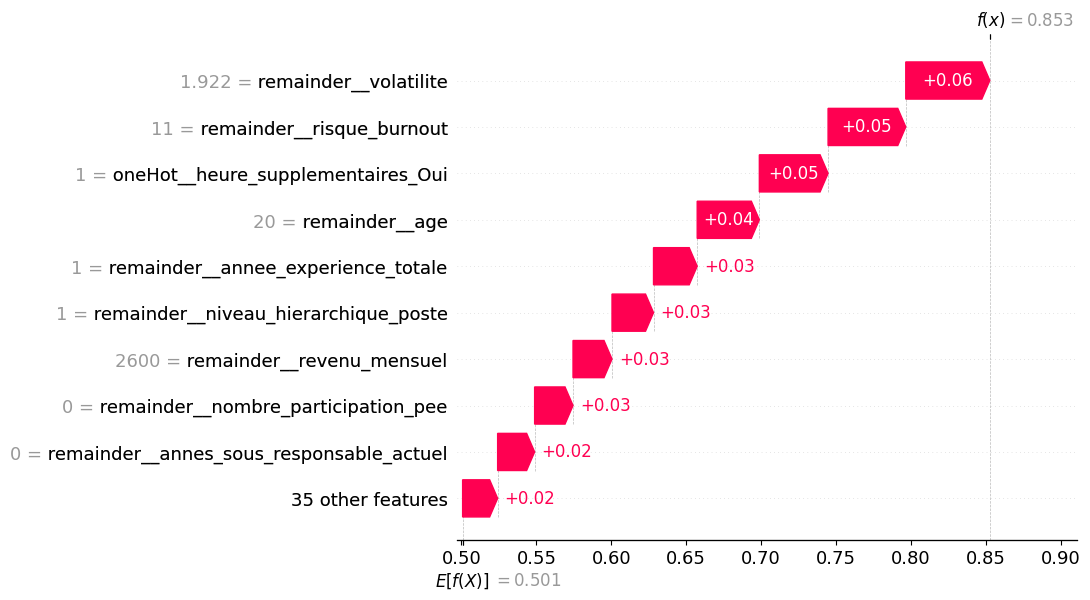

In [54]:
shap.plots.waterfall(shap_values[22, :, 1])

### Visualisation par nuage de points

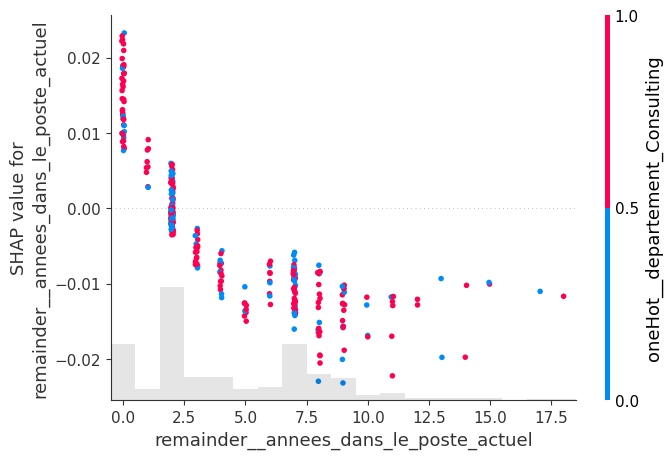

In [57]:
shap.plots.scatter(shap_values[:, 'remainder__annees_dans_le_poste_actuel', 1], color=shap_values[:, 'oneHot__departement_Consulting', 1])

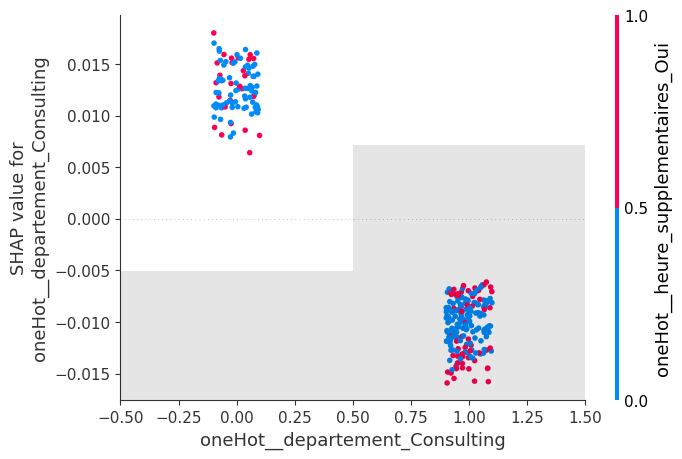

In [65]:
shap.plots.scatter(shap_values[:, 'oneHot__departement_Consulting', 1], color=shap_values[:, 'oneHot__heure_supplementaires_Oui', 1])